## Camera Calibration
Compute the camera calibration matrix and distortion coefficients based on the given set of chessboard images.

17


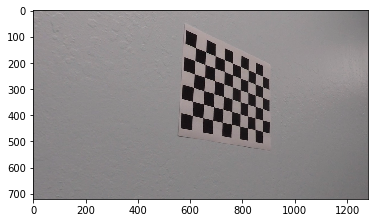

In [2]:
%matplotlib inline

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

nx = 9 #number of inside corners in x
ny = 6 #number of inside corners in y

# Read in a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
# print(images)

# Arrays to store object points and image points from all image points
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prepare object points
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) 

for image_file in images:
    img = cv2.imread(image_file)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # draw_img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        # plt.imshow(draw_img)

# Camera calibration based on objpoints and imgpoints
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Show an example of undistorted image
undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undist)
print(len(imgpoints))


## Distortion Correction

In [3]:
def undistort_image(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# Setup output path
out_path = "./output_images/"
input_path = "./test_images/"

# Read in test images
import os
test_images = os.listdir(input_path)

# Do distortion correction
for img_path in test_images:
    img = cv2.imread(input_path + img_path)
    undist_img = undistort_image(img, mtx, dist)
    cv2.imwrite(os.path.join(out_path, "undist_"+img_path), undist_img)


## Thresholded Binary Images

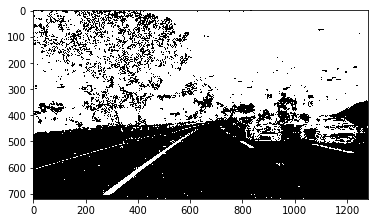

In [51]:
def threshold_image(img, sobelx_thresh = (20,110), h_thresh = (15,100), s_thresh = (140,255)):
    # Convert to HSV color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= sobelx_thresh[0]) & (scaled_sobelx <= sobelx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    
    # Combine binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (h_binary == 1) | (sxbinary == 1) ] = 255
    return combined_binary

# Do thresholding binary images
for img_path in test_images:
    img = cv2.imread(input_path + img_path)
    undist_img = undistort_image(img, mtx, dist)
    th_undist_img = threshold_image(undist_img)
    
    # Display a binary image sample
    plt.imshow(th_undist_img, 'gray')
    
    # Save binary image
    cv2.imwrite(os.path.join(out_path, "th_undist_"+ img_path), th_undist_img)

## Perspective Transform

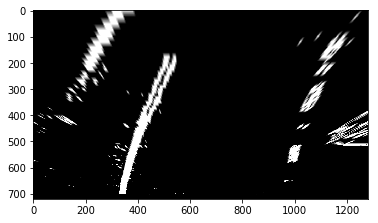

In [75]:
def perspective_trans(img, src, dst):
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img.shape[::-1], flags=cv2.INTER_LINEAR)
    return warped, M

# Manually select source and destination coordinates from straight lines
src = np.float32([[200,700],[590,450],[685,450],[1080,700]])
dst = np.float32([[280,700],[280,100],[920,100],[920,700]])

# Do perspective transform
for img_path in test_images:
    img = cv2.imread(input_path + img_path)
    undist_img = undistort_image(img, mtx, dist)
    th_undist_img = threshold_image(undist_img)
    warp_img, _ = perspective_trans(th_undist_img, src, dst)
    
    # Display a binary image sample
    plt.imshow(warp_img, 'gray')
    
    # Save binary image
    cv2.imwrite(os.path.join(out_path, "warp_"+ img_path), warp_img)

## Find Lane boundary
---
Using convolution technique.

In [79]:
def window_mask(width, height, img_ref, center, level):
    """To mask searching area inside image"""
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),
           max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(warped, window_width, window_height, margin, past_window_centroids = []):
    # Store the (left,right) window centroid positions per level
    window_centroids = []
    # Create window template for convolutions
    window = np.ones(window_width) 
    
    if not past_window_centroids:  
        
        # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
        # and then np.convolve the vertical image slice with the window template 
    
        # Sum quarter bottom of image to get slice, could use a different ratio
        l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
        l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
        r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
        r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)

        # Add what we found for the first layer
        window_centroids.append((l_center,r_center))
    
        # Go through each layer looking for max pixel locations
        for level in range(1,(int)(warped.shape[0]/window_height)):
            # convolve the window into the vertical slice of the image
            image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
            conv_signal = np.convolve(window, image_layer)
            
            # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
            offset = window_width/2
            
            # Find the best left centroid by using past left center as a reference
            l_min_index = int(max(l_center+offset-margin,0))
            l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
            
            # Find the best right centroid by using past right center as a reference
            r_min_index = int(max(r_center+offset-margin,0))
            r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
            
            window_centroids.append((l_center,r_center))
            
        return window_centroids
    
    else:
        
        for level in range(0,(int)(warped.shape[0]/window_height)):
            # Using past centeroids for each level as a reference
            l_center, r_center = past_window_centroids[level]
            
            # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
            offset = window_width/2
            
            # convolve the window into the vertical slice of the image
            image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),
                                        :], axis=0)
            conv_signal = np.convolve(window, image_layer)
 
            # Find the best left centroid by using center from previous frame as a reference
            l_min_index = int(max(l_center+offset-margin,0))
            l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
            
            # Find the best right centroid by using center from previous frame as a reference
            r_min_index = int(max(r_center+offset-margin,0))
            r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
            
            window_centroids.append((l_center,r_center))
            
        return window_centroids
    
def draw_lane_finding(warped, window_centroids):
    """To draw lane findings back to warped image"""
    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    
    return output
    # Display the final results
    # plt.imshow(output)
    # plt.title('window fitting results')
    # plt.show()

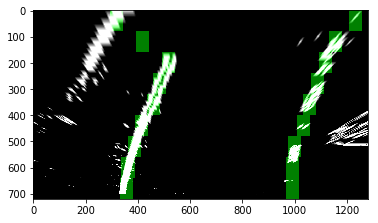

In [81]:
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

# Do lane finding
for img_path in test_images:
    img = cv2.imread(input_path + img_path)
    undist_img = undistort_image(img, mtx, dist)
    th_undist_img = threshold_image(undist_img)
    warp_img, _ = perspective_trans(th_undist_img, src, dst)
    window_centroids = find_window_centroids(warp_img, window_width, window_height, margin)
    lane_output = draw_lane_finding(warp_img, window_centroids)
    # Display a binary image sample
    plt.imshow(lane_output)
    
    # Save binary image
    cv2.imwrite(os.path.join(out_path, "lane_output_"+ img_path), lane_output)

## Create Polynomial Fit of Curve Lane Lines

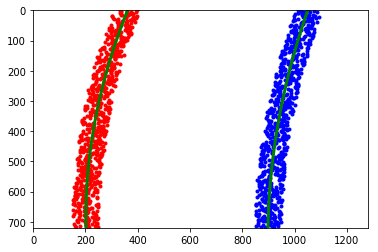

In [78]:
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images